100%|██████████| 170498071/170498071 [00:02<00:00, 78190881.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 49.1MB/s]


Epoch [1/10] - Train Accuracy: 25.10%, Test Accuracy: 32.94%
Epoch [2/10] - Train Accuracy: 34.99%, Test Accuracy: 36.41%
Epoch [3/10] - Train Accuracy: 36.42%, Test Accuracy: 37.14%
Epoch [4/10] - Train Accuracy: 37.27%, Test Accuracy: 36.93%
Epoch [5/10] - Train Accuracy: 37.72%, Test Accuracy: 37.54%
Epoch [6/10] - Train Accuracy: 38.66%, Test Accuracy: 37.67%
Epoch [7/10] - Train Accuracy: 38.43%, Test Accuracy: 38.44%
Epoch [8/10] - Train Accuracy: 39.26%, Test Accuracy: 38.77%
Epoch [9/10] - Train Accuracy: 39.27%, Test Accuracy: 38.87%
Epoch [10/10] - Train Accuracy: 39.76%, Test Accuracy: 39.62%


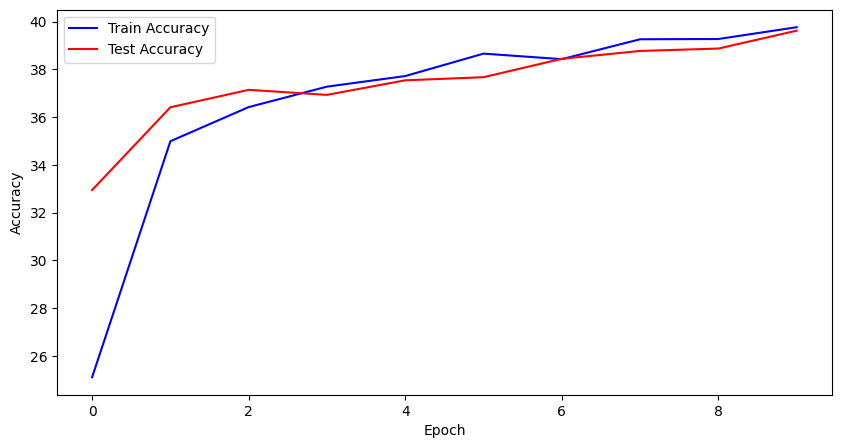

In [6]:
# Step 1: Install PyTorch analysis for ShuffleNET
!pip install torch torchvision

# Step 2: Import the necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

# Step 3: Define a function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate):
    # Define the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Lists to store training and validation accuracy for plotting
    train_accuracy = []
    test_accuracy = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        correct_alpha = 0
        total_alpha = 0

        for alpha, omega in train_loader:
            optimizer.zero_grad()
            outputs = model(alpha)
            loss = criterion(outputs, omega)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_alpha += omega.size(0)
            correct_alpha += (predicted == omega).sum().item()

        train_accuracy.append(100 * correct_alpha / total_alpha)

        # Validation loop
        model.eval()
        correct_omega = 0
        total_omega = 0

        with torch.no_grad():
            for alpha, omega in test_loader:
                outputs = model(alpha)
                _, predicted = torch.max(outputs.data, 1)
                total_omega += omega.size(0)
                correct_omega += (predicted == omega).sum().item()

            test_accuracy.append(100 * correct_omega / total_omega)

        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Accuracy: {train_accuracy[-1]:.2f}%, Test Accuracy: {test_accuracy[-1]:.2f}%')

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_accuracy, label='Train Accuracy', color='blue')
    plt.plot(range(num_epochs), test_accuracy, label='Test Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Step 4: Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 5: Load ShuffleNetV2 from torchvision
shufflenet = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
num_ftrs = shufflenet.fc.in_features

# Remove the fully connected layer
shufflenet = nn.Sequential(*list(shufflenet.children())[:-1])

# Freeze the pre-trained layers
for param in shufflenet.parameters():
    param.requires_grad = False

# Add a custom fully connected layer for CIFAR-10
model = nn.Sequential(
    shufflenet,
    nn.Flatten(),
    nn.Linear(num_ftrs, 10)  # 10 classes for CIFAR-10
)

# Step 6: Train and evaluate the model
num_epochs = 10
learning_rate = 0.001

train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate)
